In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random as ran
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (55000, 784)
y_train Examples Loaded = (55000, 10)

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


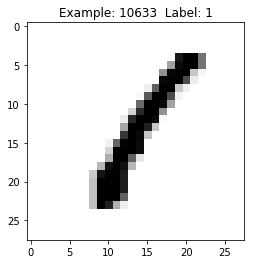

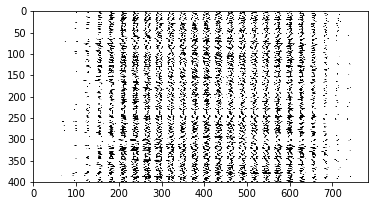

In [2]:
def train_size(num):
    print ('Total Training Images in Dataset = ' + str(mnist.train.images.shape))
    print ('--------------------------------------------------')
    x_train = mnist.train.images[:num,:]
    print ('x_train Examples Loaded = ' + str(x_train.shape))
    y_train = mnist.train.labels[:num,:]
    print ('y_train Examples Loaded = ' + str(y_train.shape))
    print('')
    return x_train, y_train

def test_size(num):
    print ('Total Test Examples in Dataset = ' + str(mnist.test.images.shape))
    print ('--------------------------------------------------')
    x_test = mnist.test.images[:num,:]
    print ('x_test Examples Loaded = ' + str(x_test.shape))
    y_test = mnist.test.labels[:num,:]
    print ('y_test Examples Loaded = ' + str(y_test.shape))
    return x_test, y_test

def display_digit(num):
    print(y_train[num])
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

def display_mult_flat(start, stop):
    images = x_train[start].reshape([1,784])
    for i in range(start+1,stop):
        images = np.concatenate((images, x_train[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()

x_train, y_train = train_size(55000)
display_digit(ran.randint(0, x_train.shape[0]))
display_mult_flat(0,400)

In [3]:
# Parameters
learning_rate = 0.001
training_iters = 500
batch_size = 128
display_step = 10
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.85 # Dropout, probability to keep units

In [4]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) 

In [5]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

In [6]:
def conv_net(x, weights, biases, dropout):
    # reshape the input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # First convolution layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling used for downsampling
    conv1 = maxpool2d(conv1, k=2)

    # Second convolution layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling used for downsampling
    conv2 = maxpool2d(conv2, k=2)

    # Reshape conv2 output to matcht the input of fully connected layer 
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])

    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output the class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [7]:
weights = {
    # 5x5 conv, 1 input, and 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, and 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, and 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs for class digits
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [8]:
pred = conv_net(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

In [9]:
train_loss = []
train_acc = []
test_acc = []

with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step <= training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            loss_train, acc_train = sess.run([cost, accuracy], 
                                             feed_dict={x: batch_x,
                                                        y: batch_y,
                                                        keep_prob: 1.})
            print "Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.2f}".format(loss_train) + ", Training Accuracy= " + \
                  "{:.2f}".format(acc_train)
    
            # Calculate accuracy for mnist test images. 
            # Note that in this case no dropout
            acc_test = sess.run(accuracy, 
                                feed_dict={x: mnist.test.images,
                                      y: mnist.test.labels,
                                      keep_prob: 1.})
    
            print "Testing Accuracy:" + \
               "{:.2f}".format(acc_train)
    
            train_loss.append(loss_train)
            train_acc.append(acc_train)
            test_acc.append(acc_test)
            
        step += 1

    

Iter 10, Minibatch Loss= 27436.70, Training Accuracy= 0.12
Testing Accuracy:0.12
Iter 20, Minibatch Loss= 8442.39, Training Accuracy= 0.51
Testing Accuracy:0.51
Iter 30, Minibatch Loss= 7687.42, Training Accuracy= 0.58
Testing Accuracy:0.58
Iter 40, Minibatch Loss= 5625.63, Training Accuracy= 0.67
Testing Accuracy:0.67
Iter 50, Minibatch Loss= 4521.98, Training Accuracy= 0.71
Testing Accuracy:0.71
Iter 60, Minibatch Loss= 2594.59, Training Accuracy= 0.81
Testing Accuracy:0.81
Iter 70, Minibatch Loss= 2250.65, Training Accuracy= 0.85
Testing Accuracy:0.85
Iter 80, Minibatch Loss= 2743.55, Training Accuracy= 0.84
Testing Accuracy:0.84
Iter 90, Minibatch Loss= 1642.03, Training Accuracy= 0.89
Testing Accuracy:0.89
Iter 100, Minibatch Loss= 2167.67, Training Accuracy= 0.84
Testing Accuracy:0.84
Iter 110, Minibatch Loss= 1964.33, Training Accuracy= 0.87
Testing Accuracy:0.87
Iter 120, Minibatch Loss= 1928.49, Training Accuracy= 0.85
Testing Accuracy:0.85
Iter 130, Minibatch Loss= 515.65, Tr

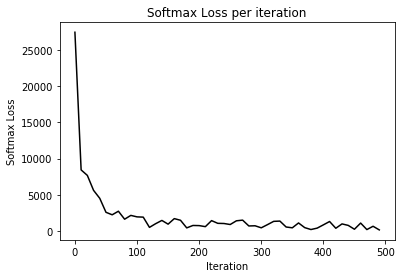

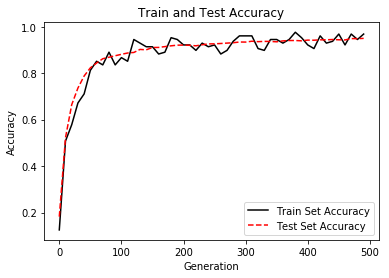

In [10]:
eval_indices = range(0, training_iters, display_step)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('Softmax Loss')
plt.show()
# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()